In [59]:
# 라이브러리 import 및 TensorFlow 버전 확인

import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [60]:
# 데이터 다운로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

In [61]:
# IN - 텍스트로 로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [62]:
# IN - Y(정답 라벨) 데이터 만들기
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [63]:
import re

def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/var/folders/rb/f6lnbfw95x9gp07rn7tzgg9w0000gn/T/ipykernel_78785/3186768405.py:13: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
/var/folders/rb/f6lnbfw95x9gp07rn7tzgg9w0000gn/T/ipykernel_78785/3186768405.py:14: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
/var/folders/rb/f6lnbfw95x9gp07rn7tzgg9w0000gn/T/ipykernel_78785/3186768405.py:15: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [ ]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)  # 단어 사전 학습
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

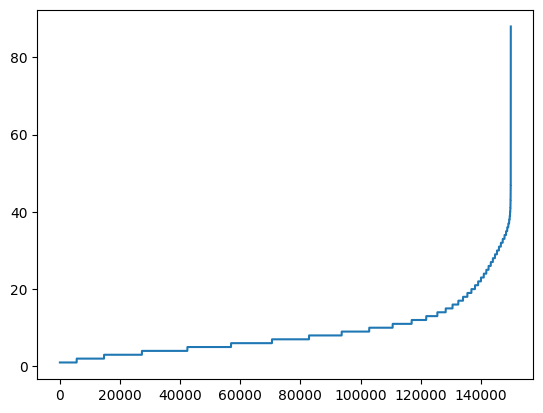

142587


In [ ]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [ ]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

# Week1에서 학습된 vectorize_layer 그대로 사용합니다.
test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)


test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [ ]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
# EPOCHS = 10
EPOCHS = 30 # ( EPOCH 30 학습 )
BATCH_SIZE = 32


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)), # 입력층
    tf.keras.layers.GlobalAveragePooling1D(), # 은닉층 1
    tf.keras.layers.Dense(64, activation='relu'), # 은닉층 2
    tf.keras.layers.Dense(1, activation='sigmoid') # 출력층
])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,321 (1.01 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7250 - loss: 0.5081 - val_accuracy: 0.7508 - val_loss: 0.4677
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7505 - loss: 0.4664 - val_accuracy: 0.7624 - val_loss: 0.4557
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7527 - loss: 0.4575 - val_accuracy: 0.7575 - val_loss: 0.4581
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7548 - loss: 0.4531 - val_accuracy: 0.7526 - val_loss: 0.4605
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7567 - loss: 0.4494 - val_accuracy: 0.7576 - val_loss: 0.4551
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7597 - loss: 0.4454 - val_accuracy: 0.7535 - val_loss: 0.4623
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7609 - loss: 0.4423 - val_accuracy: 0.7602 - val_loss: 0.4560
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7617 - loss: 0.4396 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.4871, Test Accuracy: 0.7394


In [ ]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9918
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0161
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0155
결과: 부정 😞


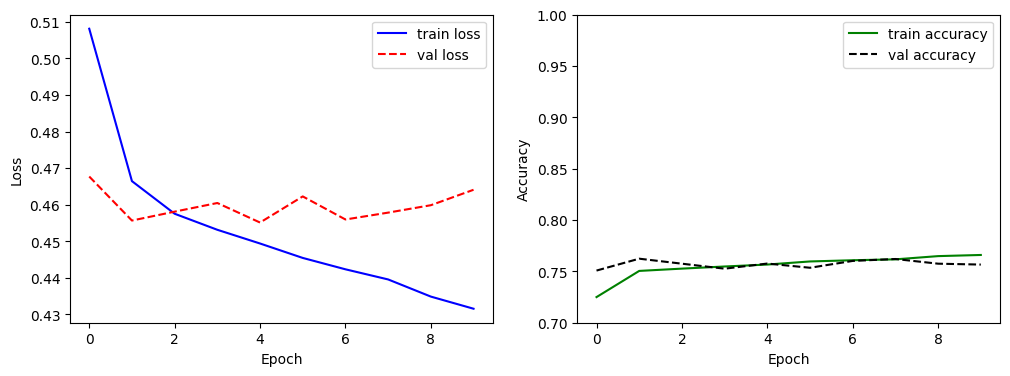

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 손실(Loss) 변화 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='train loss')       # 훈련 손실
plt.plot(history.history['val_loss'], 'r--', label='val loss')    # 검증 손실
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도(Accuracy) 변화 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='train accuracy')       # 훈련 정확도
plt.plot(history.history['val_accuracy'], 'k--', label='val accuracy')    # 검증 정확도
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)  # 정확도 범위 지정
plt.legend()

plt.show()